# Poisson's Equation

In the last lecture, we discussed the problem of finding the potential $V$ in empty regions ($\rho$ = 0) when $V$ is known on the boundaries. That is referred to as *Laplace's equation* and is most often first PDE encountered in electrodynamics.

$$
\nabla^{2} V = 0.
$$

However, we also know that we often have sources involved, in which case we have:

$$
\nabla^{2} V(\vec{r}) = -\frac{\rho(\vec{r})}{\epsilon_0}.
$$

where $\rho(\vec{r})$ is the source term at a position $\vec{r}$, and I have used the conventional units to normalize the function $\rho$. Let's look at this in more detail.

In [80]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm as colormap
%matplotlib inline

## Solving Poisson's equation

We discussed that in E&M, you're often taught the solution to Laplace's equation in two dimensions, $V(x,y)$, can be found by evaluating:

$$
V(x,y) = \frac{1}{2\pi R} \oint_{\rm circle} V dl
$$

This is due to the [*mean value property* of harmonic functions (Wikipedia)](https://en.wikipedia.org/wiki/Harmonic_function#The_mean_value_property).

Numerically, then, the primary task of this example is to evaluate, in two dimensions, the linear average of the neighboring points in a mesh with a certain range (`numxbins` vs `numybins`).

As an example in one dimension,

~~~~
# Iterate over the one dimensional space
for i in np.arange(1., numxbins):
    Vnext[i] = (V[i-1] + V[i+1])/2.
~~~~

---

## DISCUSSION

1. Discuss what your neighbor what thiss might mean in 3 dimensions.
1. What is it about the solutions to this sort of equation that give rise to the "averaging" idea?
1. Can you think of an example of comparing $V$ at a point $x,y$ to the average $\langle V \rangle$ on some boundary?

---

### Derivation of this approach

As we have done so many times, the above example in one dimension is merely a consequence of the Taylor Series of the solution.

The first derivative with respect to $x$ halfway between the locations of $V[i,j]$ and $V[i,j+1]$ can be approximated as

$$
\frac{\partial V}{\partial x} \approx \frac{\Delta V}{\Delta x} = \frac{V[i,j+1]-V[i,j]}{d}.
$$

The second derivative with respect to $x$ at the location of $V[i,j]$ can be approximated as

$$
\frac{\partial^2 V}{\partial x^2} \approx \frac{1}{d}\left[\frac{V[i+1,j]-V[i,j]}{d}-\frac{V[i,j]-V[i-1,j]}{d}\right]
 = \frac{V[i+1,j]-2V[i,j]+V[i-1,j]}{d^2} 
$$

Similarly, the second derivative with respect to $y$ at the location of $V[i,j]$ is approximately

$$
\frac{\partial^2 V}{\partial y^2} \approx \frac{V[i,j+1]-2V[i,j]+V[i,j-1]}{d^2} 
$$

The two-dimensional version of Laplace’s equation will be approximately satisfied if

$$
\frac{V[i+1,j]-2V[i,j]+V[i-1,j]}{d^2} + \frac{V[i,j+1]-2V[i,j]+V[i,j-1]}{d^2} \approx 0
$$

so

$$ 
V[i,j]\approx \frac{V[i,j+1]+V[i,j-1]+V[i+1,j]+V[i-1,j]}{4}
$$

---

## DISCUSSION

1. How does this need to change if we add a source term, $\rho$?
1. What generalizations have we made in this approximation?
1. How would those need to change in the case that we relax certain assumptions (e.g. about the size of the steps in each dimension)?

---

## Computational solution

Last time, we discussed a function that solves the two-dimensional Laplace equation for a given number of "bins" in $x$ ($numxbins$) and $y$ ($numybins$), and with a requirement on the precision of the estimation ($\epsilon$), as well as a failsafe maximum number of iterations ($imax$). Let's go into more detail with that function today

### Pseudocode

Let's sketch out some pseduocode

1. Initialize a mesh
1. Establish boundary conditions
1. Calculate neighbor sums
1. Normalize correctly: number of neighbors, size of grid
1. Account for the presence of sources
1. Iterate over whole grid
1. Running average error/difference
1. Return the calculated $V$ everywhere

In order to fill this in, ask yourself some questions:

* What are the parameters that we want the function to take?
* What values should the function return and what is their structure?
* How dynamic do we want our function to be?


### Now let's "solve Poisson"

In [82]:
def SolvePoisson(numxbins, numybins, epsilon = 1e-5, imax = 1000):

    ## Initialize the mesh with default values of zero
    V   = np.zeros((numxbins+1, numybins+1))
    rho = np.zeros((numxbins+1, numybins+1))

    ## Set boundary conditions for the problem
    ##   --> maybe these could be an arguments in the function?
    V[0,:]        = 50  ## XMin Boundary
    V[numxbins,:] = 50  ## XMax Boundary
    V[:,0]        = -10 ## YMin Boundary
    V[:,numybins] = 10  ## YMax Boundary
    
    ## Set the source term
    ##   --> maybe this could be an argument in the function?
    ##   --> how would you pass this in?
    rho[int(numxbins / 4)     , int(numybins / 4)]     =  100
    rho[int(3 * numxbins / 4) , int(3 * numybins / 4)] = -250


    ## Store previous grid values to check against error tolerance
    Vnext = V + np.zeros((numxbins+1, numybins+1))
    error = Vnext - V

    ## Constants
    k = 1          ## k is just is a counter

    ## Iterative procedure
    while k <= imax:
 
        # Iterate over the two dimensional space
        for i in np.arange(1, numxbins):

            for j in np.arange(1,  numybins):

                # Calculate the new value of the potential at this point
                # and the difference with respect to the previous value
                ##   --> what are we missing here?
                Vnext[i,j] = (V[i-1,j] + V[i+1,j] + V[i,j-1] + V[i,j+1] - rho[i,j])/4.
                error[i,j] = np.abs(Vnext[i,j] - V[i,j])

        # Set the potential to the newly calculated value and increment the counter
        V = Vnext + np.zeros((numxbins+1, numybins+1))
        k += 1
        
        # Update the maximum error across the mesh
        errmax = np.max(np.max(error))

        # Determine if the maximum error across the mesh is smaller than the specified 
        # tolerance
        if errmax < epsilon:

            print("Convergence after ", k, " iterations.")
            return V

    print("No convergence after ", k, " iterations.")
    return False

---
## DISCUSSION

1. Modify the function to take rho as an argument. How did you do this?
1. Have we correctly minimized $V(x,y)$? How should we update this to do so?

---

### Plotting function

Function that handles the plotting of a function $V(x,y)$ for a given range in $x$ ($numxbins$) and $y$ ($numybins$) and spacing ($stepsize$) in both dimensions

In [83]:
def PlotSolution(numxbins,numybins,stepsize,V):

    ## Set up x and y vectors for meshgrid
    x = np.linspace(0, numxbins * stepsize, numxbins+1)
    y = np.linspace(0, numybins * stepsize, numybins+1)

    # set up a figure that is wider than it is tall since we want the figures
    # to be side by side
    figure = plt.figure(figsize=(20,8))
    
    # My colormap: see https://matplotlib.org/users/colormaps.html
    # mycmap = colormap.viridis
    mycmap = colormap.plasma
    # mycmap = colormap.inferno
    # mycmap = colormap.magma
    
    
    # set up the axes for the first plot
    ax = figure.add_subplot(1, 2, 1, projection='3d')
    X,Y  = np.meshgrid(x,y)
    surf = ax.plot_surface(X, Y, V.transpose(), cmap=mycmap, linewidth=0, antialiased=False)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("V(x,y)")

    # set up the axes for the second plot
    ax = figure.add_subplot(1, 2, 2)
    cs   = plt.contourf(X, Y, V.transpose(), 32, cmap=mycmap)
    cbar = plt.colorbar()
    cbar.set_label('V(x,y)')
    plt.xlabel("x")
    plt.ylabel("y")

    plt.show()

### Plot the results

Convergence after  1095  iterations.


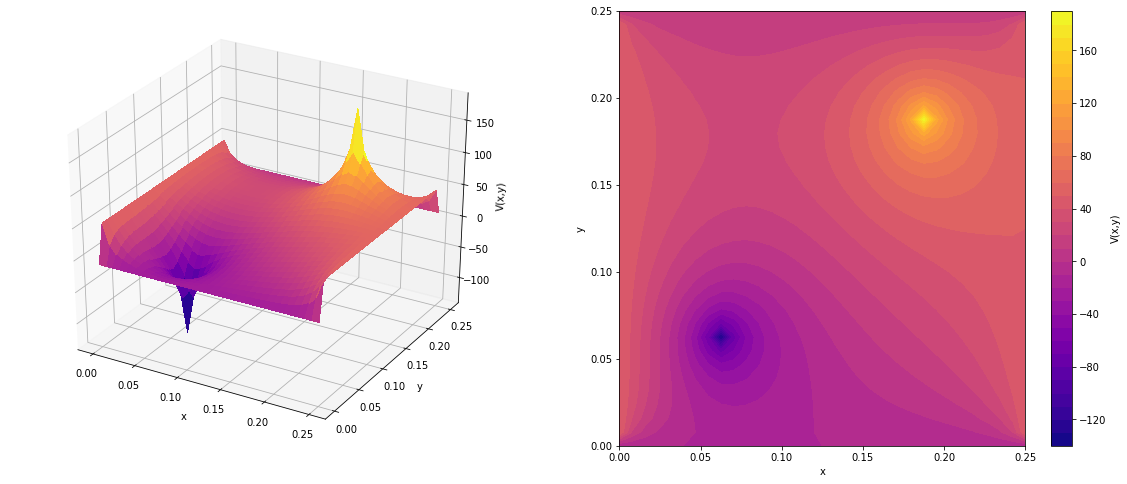

In [84]:
## Size of plate and mesh
numxbins = 32
numybins = 32
stepsize = 1./128.

## Tolerance and failsafe
epsilon = 1e-3     ## Absolute Error tolerance
imax    = 10000    ## Maximum number of iterations allowed

## Calculate the scalar function V
V = SolvePoisson(numxbins, numybins, epsilon, imax)

## Plot V
PlotSolution(numxbins, numybins, stepsize, V)
plt.show()

---

## DISCUSSION

1. How would you animate this?
1. How would you extrapolate to a different type of equation?

---